<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=250, height=250>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Embeddings

Привет! В этом домашнем задании мы с помощью эмбеддингов решим задачу семантической классификации твитов.

Для этого мы воспользуемся предобученными эмбеддингами word2vec.

Для начала скачаем датасет для семантической классификации твитов:

In [ ]:
!gdown https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph&export=download
!unzip archive.zip

Импортируем нужные библиотеки:

In [ ]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import nltk
import gensim
import gensim.downloader as api

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cpu'

In [ ]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin", header=None, names=["emotion", "id", "date", "flag", "user", "text"])

Посмотрим на данные:

In [ ]:
data.head()

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Выведем несколько примеров твитов, чтобы понимать, с чем мы имеем дело:

In [ ]:
examples = data["text"].sample(10)
print("\n".join(examples))

@chrishasboobs AHHH I HOPE YOUR OK!!! 
@misstoriblack cool , i have no tweet apps  for my razr 2
@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
upper airways problem 
Going to miss Pastor's sermon on Faith... 
on lunch....dj should come eat with me 
@piginthepoke oh why are you feeling like that? 
gahh noo!peyton needs to live!this is horrible 
@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


Как видим, тексты твитов очень "грязные". Нужно предобработать датасет, прежде чем строить для него модель классификации.

Чтобы сравнивать различные методы обработки текста/модели/прочее, разделим датасет на dev(для обучения модели) и test(для получения качества модели).

In [ ]:
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
dev_size = math.ceil(data.shape[0] * 0.8) # 80% данных для обучения модели

dev_indexes = indexes[:dev_size]
test_indexes = indexes[dev_size:]

dev_data = data.iloc[dev_indexes]
test_data = data.iloc[test_indexes]

dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

## Обработка текста

Токенизируем текст, избавимся от знаков пунктуации и выкинем все слова, состоящие менее чем из 4 букв:

In [ ]:
tokenizer = nltk.WordPunctTokenizer()
line = tokenizer.tokenize(dev_data["text"][0].lower())
print(" ".join(line))

@ claire_nelson i ' m on the north devon coast the next few weeks will be down in devon again in may sometime i hope though !


In [ ]:
line

['@',
 'claire_nelson',
 'i',
 "'",
 'm',
 'on',
 'the',
 'north',
 'devon',
 'coast',
 'the',
 'next',
 'few',
 'weeks',
 'will',
 'be',
 'down',
 'in',
 'devon',
 'again',
 'in',
 'may',
 'sometime',
 'i',
 'hope',
 'though',
 '!']

In [ ]:
filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
print(" ".join(filtered_line))

north devon coast next weeks will down devon again sometime hope though


In [ ]:
filtered_line

['north',
 'devon',
 'coast',
 'next',
 'weeks',
 'will',
 'down',
 'devon',
 'again',
 'sometime',
 'hope',
 'though']

Загрузим предобученную модель эмбеддингов. 

Если хотите, можно попробовать другую. Полный список можно найти здесь: https://github.com/RaRe-Technologies/gensim-data.

Данная модель выдает эмбеддинги для **слов**. Строить по эмбеддингам слов эмбеддинги предложений мы будем ниже.

In [ ]:
word2vec = api.load("word2vec-google-news-300")

In [ ]:
emb_line = [word2vec.get_vector(w) for w in filtered_line if w in word2vec]
print(sum(emb_line).shape)

(300,)


In [ ]:
len(emb_line), emb_line[0].shape

(12, (300,))

Нормализуем эмбеддинги, прежде чем обучать на них сеть. 
(наверное, вы помните, что нейронные сети гораздо лучше обучаются на нормализованных данных)

In [ ]:
mean = np.mean(word2vec.vectors, 0)
std = np.std(word2vec.vectors, 0)
norm_emb_line = [(word2vec.get_vector(w) - mean) / std for w in filtered_line if w in word2vec and len(w) > 3]
print(sum(norm_emb_line).shape)
print([all(norm_emb_line[i] == emb_line[i]) for i in range(len(emb_line))])

(300,)
[False, False, False, False, False, False, False, False, False, False, False, False]


In [ ]:
len(norm_emb_line), norm_emb_line[0].shape

(12, (300,))

Сделаем датасет, который будет по запросу возвращать подготовленные данные.

In [ ]:
from torch.utils.data import Dataset, random_split


class TwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        # Получи все токены из текста и профильтруй их
        return [word for word in self.tokenizer.tokenize(text.lower()) if all(c not in string.punctuation for c in word) and len(word) > 3]

    def get_embeddings_(self, tokens):
        # Получи эмбеддинги слов и усредни их
        embeddings = [(self.word2vec.get_vector(word) - self.mean) / self.std for word in tokens if word in self.word2vec]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
dev = TwitterDataset(dev_data, "text", "emotion", word2vec)

Отлично, мы готовы с помощью эмбеддингов слов превращать твиты в векторы и обучать нейронную сеть.

Превращать твиты в векторы, используя эмбеддинги слов, можно несколькими способами. А именно такими:

## Average embedding (2 балла)
---
Это самый простой вариант, как получить вектор предложения, используя векторные представления слов в предложении. А именно: вектор предложения есть средний вектор всех слов в предложении (которые остались после токенизации и удаления коротких слов, конечно). 

In [ ]:
indexes = np.arange(len(dev))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


In [ ]:
# Посмотрим на то, что из себя представляют "features"

In [ ]:
examples["features"][0].shape 

(300,)

In [ ]:
examples["features"][0]

array([ 7.9884803e-01,  2.9639465e-01, -2.2475016e-01,  8.2761788e-01,
       -3.1564566e-01, -1.6312727e-01,  1.7091973e-01, -2.3886690e-01,
        1.3271519e+00,  7.9067945e-02, -3.7298936e-01, -6.2446344e-01,
       -4.5519450e-01, -6.0943842e-01, -8.8517392e-01,  3.5065675e-01,
        3.0780718e-01,  6.7162788e-01,  4.2289284e-01,  2.1005470e-01,
       -7.7801168e-01,  3.7947506e-01,  6.3729638e-01, -6.4212009e-02,
       -2.1386537e-01,  6.5230477e-01,  5.6758843e-02, -1.4959922e-01,
       -1.0668172e-01,  7.2228706e-01,  3.5502084e-02,  3.3637053e-01,
       -3.5735342e-01,  1.4720384e-02,  5.6321281e-01,  1.0573757e+00,
       -1.0641952e-01, -7.5060594e-01,  1.1950602e-01,  5.7973540e-01,
        7.0914221e-01, -5.5394304e-01,  1.0270479e+00, -8.7821597e-01,
        2.4422202e-01,  6.0519435e-02,  6.4671451e-01,  7.5697160e-01,
       -8.9677095e-01,  1.1938182e-01,  1.0028274e+00,  2.0390332e-01,
        6.8945684e-02, -6.1266530e-01,  2.9391396e-01, -3.9199635e-01,
      

Давайте сделаем визуализацию полученных векторов твитов тренировочного (dev) датасета. Так мы увидим, насколько хорошо твиты с разными target значениями отделяются друг от друга, т.е. насколько хорошо усреднение эмбеддингов слов предложения передает информацию о предложении.

Для визуализации векторов надо получить их проекцию на плоскость. Сделаем это с помощью `PCA`. Если хотите, можете вместо PCA использовать TSNE: так у вас получится более точная проекция на плоскость (а значит, более информативная, т.е. отражающая реальное положение векторов твитов в пространстве). Но TSNE будет работать намного дольше.

In [ ]:
# 1280*300 -> 1280*2 - преобразование PCA, которого мы добиваемся

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(examples["features"]) # Обучи PCA на эмбеддингах слов

In [ ]:
examples["transformed_features"].shape

(1280, 2)

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1003', ...)

Скорее всего, на визуализации нет четкого разделения твитов между классами. Это значит, что по полученным нами векторам твитов не так-то просто определить, к какому классу твит пренадлежит. Значит, обычный линейный классификатор не очень хорошо справится с задачей. Надо будет делать глубокую (хотя бы два слоя) нейронную сеть.

Подготовим загрузчики данных.
Усреднее векторов будем делать в "батчевалке"(`collate_fn`). Она используется для того, чтобы собирать из данных `torch.Tensor` батчи, которые можно отправлять в модель.


In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 4

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

Определим функции для тренировки и теста модели:

In [ ]:
from tqdm.notebook import tqdm


def training(model, optimizer, criterion, train_loader, epoch, device="cpu"):
    pbar = tqdm(train_loader, desc=f"Epoch {e + 1}. Train Loss: {0}")
    model.train()
    
    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)

        # Получи предсказания модели
        # Посчитай лосс
        # Обнови параметры модели
        optimizer.zero_grad()

        logits = model(features)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {e + 1}. Train Loss: {loss:.4}")
    

def testing(model, criterion, test_loader, device="cpu"):
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    
    mean_loss = 0
    mean_acc = 0

    model.eval()
    with torch.no_grad():

        for batch in pbar:
            features = batch["features"].to(device)
            targets = batch["targets"].to(device)

            # Получи предсказания модели
            # Посчитай лосс
            # Посчитай точность модели

            logits = model(features) 
            loss = criterion(logits, targets)
            acc = (logits.argmax(dim=1) == targets).type(torch.float).mean()

            mean_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

    pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")

    return {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader)}

Создадим модель, оптимизатор и целевую функцию. Вы можете сами выбрать количество слоев в нейронной сети, ваш любимый оптимизатор и целевую функцию.


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, embeddings_dim, n_classes):
        super(NeuralNetwork, self).__init__()
        self.linear_1 = nn.Linear(embeddings_dim, 256)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(256, 128)
        self.linear_3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))

        logits = self.linear_3(x)
        return logits

In [ ]:
import torch.nn as nn
from torch.optim import Adam


# Не забудь поиграться с параметрами ;)
vector_size = dev.word2vec.vector_size
num_classes = 2
lr = 1e-4
num_epochs = 2

model = NeuralNetwork(embeddings_dim=vector_size, n_classes=num_classes) # Твоя модель
model = model.to(device)
criterion = nn.CrossEntropyLoss() # Твой лосс
optimizer = torch.optim.Adam(model.parameters()) # Твой оптимайзер

Наконец, обучим модель и протестируем её.

После каждой эпохи будем проверять качество модели на валидационной части датасета. Если метрика стала лучше, будем сохранять модель. **Подумайте, какая метрика (точность или лосс) будет лучше работать в этой задаче?** 

In [ ]:
best_metric = np.inf
for e in range(num_epochs):
    training(model, optimizer, criterion, train_loader, e, device)
    log = testing(model, criterion, valid_loader, device)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]

Epoch 1. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.5037948249578476, 'Test Acc': 0.75125390625}


Epoch 2. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.49697556138038634, 'Test Acc': 0.755859375}


In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

{'Test Loss': 0.49849567026756825, 'Test Acc': 0.7552447334265175}


## Embeddings for unknown words (8 баллов)

Пока что использовалась не вся информация из текста. Часть информации фильтровалось – если слова не было в словаре эмбеддингов, то мы просто превращали слово в нулевой вектор(МОЙ КОММЕНТАРИЙ: не согласен... мы не превращали слово в нулевой вектор, а пропускали его). Хочется использовать информацию по-максимуму. Поэтому рассмотрим другие способы обработки слов, которых нет в словаре. А именно:

- Для каждого незнакомого слова будем запоминать его контекст(слова слева и справа от этого слова). Эмбеддингом нашего незнакомого слова будет сумма эмбеддингов всех слов из его контекста. (4 балла)
- Для каждого слова текста получим его эмбеддинг из Tfidf с помощью ```TfidfVectorizer``` из [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Итоговым эмбеддингом для каждого слова будет сумма двух эмбеддингов: предобученного и Tfidf-ного. Для слов, которых нет в словаре предобученных эмбеддингов, результирующий эмбеддинг будет просто полученный из Tfidf. (4 балла)

Реализуйте оба варианта **ниже**. Напишите, какой способ сработал лучше и ваши мысли, почему так получилось.

In [ ]:
# 1-ый вариант
# Для реализации 1-ого варианта переопредлим метод get_embeddings_ класса TwitterDataset

In [ ]:
class Custom_TwitterDataset_v1(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, window_size=1):
        super(Custom_TwitterDataset_v1, self).__init__(data, feature_column, target_column, word2vec)
        self.window_size = window_size

    def get_embeddings_(self, tokens):
        embeddings = []

        for i, word in enumerate(tokens):
            if word not in self.word2vec: # если слова нет среди предобученных эмбеддингов, расчитываем его эмбеддинг по его контенту
                left_context = max(0, i - self.window_size)
                right_context = min(len(tokens) - 1, i + self.window_size)

                context = tokens[left_context: i] + tokens[i + 1: right_context]
                embedding = [(self.word2vec.get_vector(context_word) - self.mean) / self.std for context_word in context if context_word in self.word2vec]
                
                if not len(embedding):
                    embedding = np.zeros(self.word2vec.vector_size)
                else:
                    embedding = np.sum(embedding, axis=0)

                embeddings.append(embedding)
            else:
                embeddings.append((self.word2vec.get_vector(word) - self.mean) / self.std)

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

In [ ]:
custom_dev_v1 = Custom_TwitterDataset_v1(dev_data, "text", "emotion", word2vec)

In [ ]:
train_v1, valid_v1 = random_split(custom_dev_v1, [train_size, len(custom_dev_v1) - train_size])

train_loader_v1 = DataLoader(train_v1, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader_v1 = DataLoader(valid_v1, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
best_metric = np.inf
for e in range(num_epochs):
    training(model, optimizer, criterion, train_loader_v1, e, device)
    log = testing(model, criterion, valid_loader_v1, device)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model_v1.pt")
        best_metric = log["Test Loss"]

Epoch 1. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.4912253110408783, 'Test Acc': 0.7586015625}


Epoch 2. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.48985003197193144, 'Test Acc': 0.75958203125}


In [ ]:
test_loader_v1 = DataLoader(
    Custom_TwitterDataset_v1(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model_v1.pt", map_location=device))

print(testing(model, criterion, test_loader_v1, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

{'Test Loss': 0.4944828003168868, 'Test Acc': 0.7570418580271565}


In [ ]:
# Для реализации 2-ого варианта реализуем вспомогательные функции для создания словаря tfidf_embeddings 
# 

In [ ]:
# установим sparsesvd для svd разложения разряженной матрицы tfidf корпуса документов
!pip install sparsesvd

In [ ]:
from sparsesvd import sparsesvd
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_embeddings(corpus_docs, embedding_size=300):
    tfidf_vectorizer = TfidfVectorizer(min_df=5)
    sparse_matrix_tfidf = tfidf_vectorizer.fit_transform(corpus_docs)
    
    u, s, vt = sparsesvd(sparse_matrix_tfidf.tocsc(), embedding_size)
    k, v = tfidf_vectorizer.get_feature_names(), vt.T

    return {k[i]: v[i] for i in range(len(v))}

In [ ]:
tfidf_embeddings = get_tfidf_embeddings(corpus_docs=data["text"].values, embedding_size=300)

In [ ]:
class Custom_TwitterDataset_v2(TwitterDataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        super(Custom_TwitterDataset_v2, self).__init__(data, feature_column, target_column, word2vec)

        self.tfidf_embeddings = tfidf_embeddings
    
    '''def get_tokens_(self, text):
        if not hasattr(self, "tokens"):
            nltk.download("wordnet")
            nltk.download("stopwords")
            self.tokenize = nltk.word_tokenize
            self.norm = nltk.WordNetLemmatiizer().lemmatize
            self.stopWords = set(nltk.corpus.stopwords.words("english"))
            
            self.check = lambda token: ((token.isalnum()) and (token not in self.stopWords))
            self.tokens = [self.norm(token) for token in self.tokenize(text.lower()) if self.check(token)]
        return self.tokens'''

    def get_embeddings_(self, tokens):
        embeddings = []

        for i, word in enumerate(tokens):
            if word not in self.word2vec:
                if word in self.tfidf_embeddings:
                    embeddings.append((self.tfidf_embeddings[word] - self.mean) / self.std)
                else:
                    pass
            else:
                if word in self.tfidf_embeddings:
                    embeddings.append((self.word2vec.get_vector(word) + self.tfidf_embeddings[word] - self.mean) / self.std)
                else:
                    embeddings.append((self.word2vec.get_vector(word) - self.mean) / self.std)

                    
        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

In [ ]:
custom_dev_v2 = Custom_TwitterDataset_v2(dev_data, "text", "emotion", word2vec)

In [ ]:
train_v2, valid_v2 = random_split(custom_dev_v2, [train_size, len(custom_dev_v2) - train_size])

train_loader_v2 = DataLoader(train_v2, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader_v2 = DataLoader(valid_v2, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
best_metric = np.inf
for e in range(num_epochs):
    training(model, optimizer, criterion, train_loader_v2, e, device)
    log = testing(model, criterion, valid_loader_v2, device)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model_v2.pt")
        best_metric = log["Test Loss"]

Epoch 1. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.4801198878288269, 'Test Acc': 0.7663671875}


Epoch 2. Train Loss: 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.48139447152614595, 'Test Acc': 0.76566796875}


In [ ]:
test_loader_v2 = DataLoader(
    Custom_TwitterDataset_v2(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model_v2.pt", map_location=device))

print(testing(model, criterion, test_loader_v2, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

{'Test Loss': 0.49097904572471646, 'Test Acc': 0.759837385183706}


In [ ]:
# Значения метрик(train + val data), которые были получены только с помощью word2vec

# на втором скрине(test data)

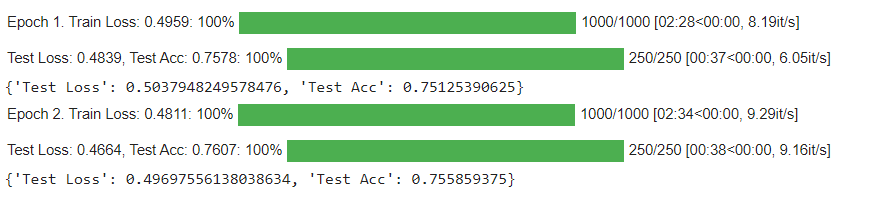

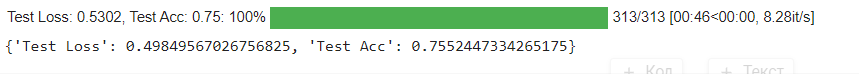

In [ ]:
# Были реализованы 2 дополнительных способа обработки слов(которые не содержались в словаре предобученного word2vec)

# 1-ый способ состоят в том, чтобы предсавить "незнакомое" слово его контентом(ближайшие к нему соседи справа и слева)

# 2-ой способ состоит в том, чтобы приплюсовать к эмбеддингам слова, эмбеддинги tfidf, полученные на обучающих данных

In [ ]:
# 1-ый способ

# Значения метрик(train + val data), которые были получены только с помощью word2vec

# на втором скрине(test data)

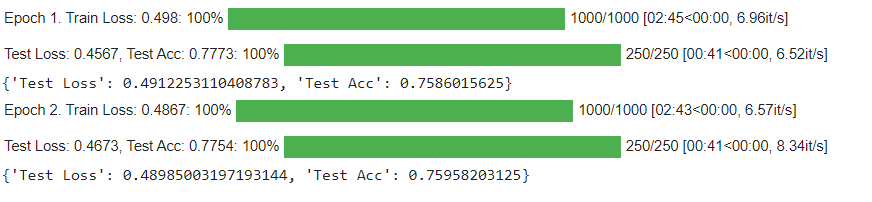

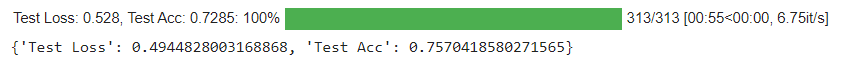

In [ ]:
# 2-ой способ

# Значения метрик(train + val data), которые были получены только с помощью word2vec

# на втором скрине(test data)

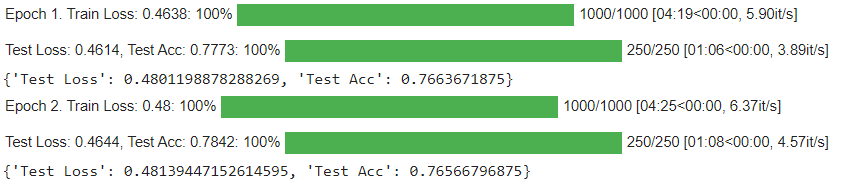

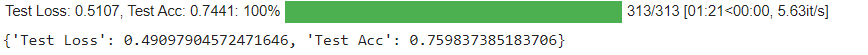

In [ ]:
# Выводы:

# Конечно же делать выводы и обобщать их на все случаи, учитывая лишь частный случай мы не можем, но конкретно данный датасет на 2х эпохах обучения(делать
# большее кол-во эпох особо эффекта не привнесло) и при данной тестовой выборке дают следующие результаты:

# По скринам выше(на них приведены логи метрик и лосс на обучении, валидации и тесте), 2 методики, которые мы применили дают небольшой прирост accuracy
# по сравнению с тем, когда используется исключительно word2vec.
# На самом деле - это ожидаемый результат т.к. бех доп. подъодов мы просто теряем информацию о словах, которых нет в word2vec, а это уже в свою очередь
# очень сильно коррелирует с тем, какой именно word2vec мы используем(смотря на каком корпусе документов он был обучен).

# Между 2-мя способами лучше себя показал подход с использванием tfidf.
# Могу предположить, что 1-ый подход показал себя хуже т.к. представить слово через усреднение его контента впринципе можно, но далеко не всегда
# данный подход будет корректен... 

# А подход tfidf лишь вносит дополнительную информацию в пространство word2vec, что позволяет модели лучше проводить семантическую классификацию